In [836]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt

#! Use this to get an idea on how it functions, this does not represent it properly.
#! It works well, still has crucial missing steps 

"""
# Evaluating the network on the validation set 
val_outputs = model(x_test)
val_loss = criterion(val_outputs, y_test)
print(val_loss)
"""

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Frame

In [837]:
# Forming the Training LF and HF Points
def lf(x):
    return 0.5*np.sin(x * (10 * math.pi))*x
    
def hf(x): 
    return 1.8*np.sin(x * (10 * math.pi))*2*x

# Data Array
X = torch.linspace(0, 1, 1000)[:,np.newaxis]

# Number of HF and LF points
Nhf = 10
Nlf = 100

# LF and HF training points
x_LF_train = np.random.permutation(X)[0:Nlf]
x_HF_train = np.random.permutation(x_LF_train)[0:Nhf]

x_LF_train = torch.from_numpy(x_LF_train)
x_HF_train = torch.from_numpy(x_HF_train)

y_LF_train = lf(x_LF_train)
y_HF_train = hf(x_HF_train)

# Hyper Parameters


In [838]:
# LF NN Hyper Paramters
LF_num_epochs = 800
LF_hidden_dims = ([200, 400, 600, 800, 1000])

# HF NN Hyper Paramters
HF_num_epochs = 400
HF_hidden_dims = (10*[200, 400, 600, 800, 1200, 1600, 2400])

# MFNN Hyper Paramters
MF_num_epochs = 200
MF_hidden_dims = ([20, 50, 60, 80, 120, 160, 240])

In [839]:
# LF NN Hyper Paramters
input_dim = 1
output_dim = 1

# Low Fidelity Neural Network
class NeuralNetwork(torch.nn.Module):
  def __init__(self, input_dim, LF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, LF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(LF_hidden_dims[0], LF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(LF_hidden_dims[1], LF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(LF_hidden_dims[2], LF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(LF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    # x = self.dropout(x)
    x = self.fc5(x)
    return x

LF_model = NeuralNetwork(input_dim, LF_hidden_dims, output_dim).to(device)

for param in LF_model.parameters():
  param.requires_grad = True

In [840]:
# Low Fidelity Model Training

# Define the criterion and optimizer
criterion = torch.nn.MSELoss().to(device) # Fixed Criterion for both Networks
LF_optimizer = torch.optim.Adam(LF_model.parameters())

# Training Step
LF_losses = []
for epoch in range(LF_num_epochs):
  LF_y_pred = LF_model(x_LF_train.to(device))
  LF_loss = criterion(LF_y_pred, y_LF_train.to(device))
  LF_losses.append(LF_loss.item())
  LF_optimizer.zero_grad()
  LF_loss.backward()
  LF_optimizer.step()

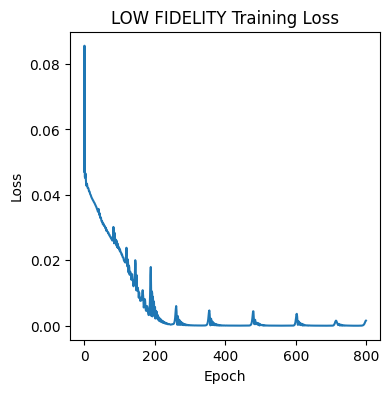

Final loss value:  0.0015693638706579804


In [841]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(LF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOW FIDELITY Training Loss')
plt.show()

print("Final loss value: ", LF_loss.item())

In [842]:
# HF NN Hyper Paramters
input_dim = 1

# High Fidelity Neural Network
class HighFidelityNetwork(torch.nn.Module):
  def __init__(self, input_dim, HF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, HF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(HF_hidden_dims[0], HF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(HF_hidden_dims[1], HF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(HF_hidden_dims[2], HF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(HF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    # x = self.dropout(x)
    x = self.fc5(x)
    return x

HF_model = HighFidelityNetwork(input_dim, HF_hidden_dims, output_dim).to(device)

for param in HF_model.parameters():
  param.requires_grad = True

In [843]:
# High Fidelity Model Training

# Define the optimizer
HF_optimizer = torch.optim.Adam(HF_model.parameters())

# Training Step
HF_losses = []
for epoch in range(HF_num_epochs):
  HF_y_pred = HF_model(x_HF_train.to(device))
  HF_loss = criterion(HF_y_pred, y_HF_train.to(device))
  HF_losses.append(HF_loss.item())
  HF_optimizer.zero_grad()
  HF_loss.backward()
  HF_optimizer.step()

  
for param in HF_model.parameters():
  param.requires_grad = True

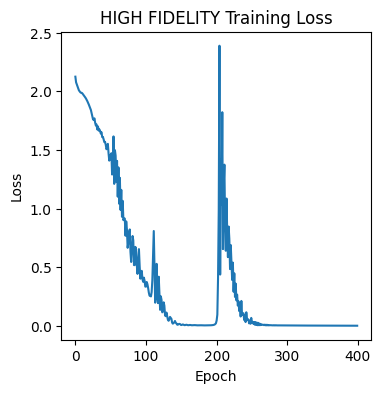

Final loss value:  0.0005005454877391458


In [844]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(HF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HIGH FIDELITY Training Loss')
plt.show()

print("Final loss value: ", HF_loss.item())

In [845]:
# Step 1: Predict HF points with LF Model
# Step 2: Add X_HF Points and output of the predictions from Step 1
# Step 3: Create a Third NN Model fitting the new X_HF Array from Step 2 and Y_HF_TRAIN values
# Step 4: Add X...? and output of the LF model (similar to Step 2)
# Step 5: Predict this new arrray with the MFNN model from Step 3

In [846]:
# Step 1: Predict HF points with LF Model & Step 2: Add X_HF Points and output of the predictions from Step 1
L1mean = LF_model(x_HF_train.to(device))

print(L1mean.shape)

L2train = np.hstack((x_HF_train, L1mean.cpu().detach().numpy()))
L2train = torch.from_numpy(L2train) 
print(L2train.shape)

torch.Size([10, 1])
torch.Size([10, 2])


In [847]:
# Step 3: Create a Third NN Model fitting the new X_HF Array from Step 2 and Y_HF_TRAIN values
# MFNN Hyper Paramters
input_dim = 2

# High Fidelity Neural Network
class MultiFidelityNetwork(torch.nn.Module):
  def __init__(self, input_dim, MF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, MF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(MF_hidden_dims[0], MF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(MF_hidden_dims[1], MF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(MF_hidden_dims[2], MF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(MF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    # x = self.dropout(x)
    x = self.fc5(x)
    return x

MF_model = MultiFidelityNetwork(input_dim, MF_hidden_dims, output_dim).to(device)

for param in MF_model.parameters():
  param.requires_grad = True

In [848]:
# Multi Fidelity Model Training

# Define the optimizer
MF_optimizer = torch.optim.Adam(MF_model.parameters())

# Training Step
MF_losses = []
for epoch in range(MF_num_epochs):
  MF_y_pred = MF_model(L2train.to(device))
  MF_loss = criterion(MF_y_pred, y_HF_train.to(device))
  MF_losses.append(MF_loss.item())
  MF_optimizer.zero_grad()
  MF_loss.backward()
  MF_optimizer.step()
  
for param in MF_model.parameters():
  param.requires_grad = True

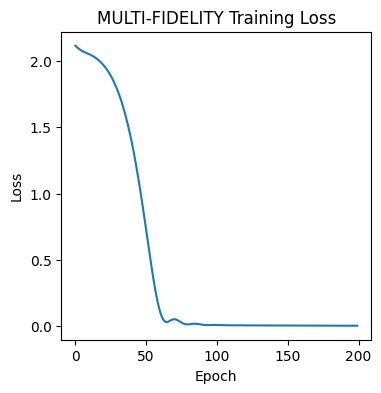

Final loss value:  0.0045806849375367165


In [849]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(MF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MULTI-FIDELITY Training Loss')
plt.show()

print("Final loss value: ", MF_loss.item())

In [850]:
# Running the Models with LF and HF points
y_pred_lf = LF_model(X.to(device))
y_pred_hf = HF_model(X.to(device))

In [851]:
# Step 4: Add X...? and output of the LF model (similar to Step 2)
# Step 5: Predict this new arrray with the MFNN model from Step 3

L2test = np.hstack((X, y_pred_lf.cpu().detach().numpy()))
L2test = torch.from_numpy(L2test)
print(L2test.shape)

y_pred_mf = MF_model(L2test.to(device))


torch.Size([1000, 2])


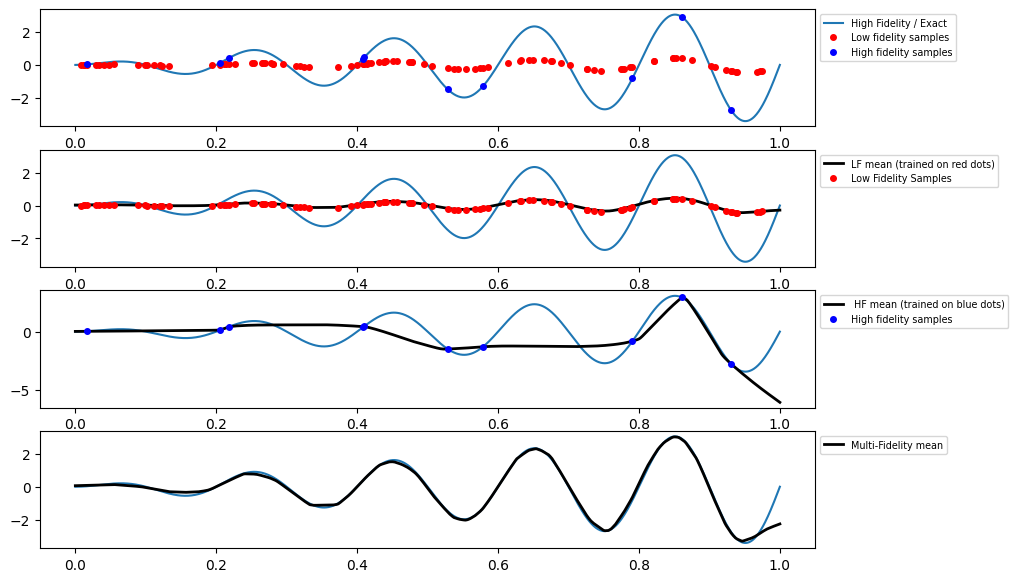

In [852]:
# Plotting the predictions against the true values after converting from CUDA to CPU's memory
fig, axs = plt.subplots(4, figsize = (10, 7))

axs[0].plot(X,hf(X), label= "High Fidelity / Exact") # main result line we want to match with
axs[0].plot(x_LF_train, lf(x_LF_train), 'ro', markersize = 4, label = "Low fidelity samples")
axs[0].plot(x_HF_train, hf(x_HF_train), 'bo', markersize = 4, label = "High fidelity samples")
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

axs[1].plot(X, hf(X)) 
axs[1].plot(X, y_pred_lf.cpu().detach().numpy(),'k', lw=2, label= "LF mean (trained on red dots)")
axs[1].plot(x_LF_train, lf(x_LF_train), 'ro', markersize = 4, label = 'Low Fidelity Samples')
axs[1].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

axs[2].plot(X, hf(X))
axs[2].plot(X, y_pred_hf.cpu().detach().numpy(), 'k', lw=2, label=" HF mean (trained on blue dots)")
axs[2].plot(x_HF_train, hf(x_HF_train),'bo', markersize = 4, label="High fidelity samples")
axs[2].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

axs[3].plot(X, hf(X))
axs[3].plot(X, y_pred_mf.cpu().detach().numpy(), 'k', lw=2, label="Multi-Fidelity mean")
axs[3].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
